In [89]:
import os
import cv2
from math import ceil,sqrt
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import time
import math
import cmath
import sys
from scipy.ndimage import morphology as morph
from skimage.morphology import disk
IMAGES_FOLDER_PATH = "/content/"

##Question 1

In [54]:
def verify(img, SE):
    for i in range(3):
        for j in range(3):
            if SE[i][j] != -1 and SE[i][j] != img[i][j]:
                return 0
    return 1

def apply_filter(img, s):
    copy = img.copy()
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            mat = img[i-1:i+2, j-1: j+2]
            if verify(mat, s) == 1:
                copy[i,j] = 0
    return copy
    
def skeletonization(input_img, showIters = False):
    s1 = np.array([[0,0,0],[-1,1,-1],[1,1,1]])
    s2 = np.array([[-1,0,0],[1,1,0],[-1,1,-1]])
    inp = input_img.copy()
    while True:
        prev_img = inp.copy()
        inp = apply_filter(inp, s1)
        inp = apply_filter(inp, s2)
        inp = apply_filter(inp, np.rot90(s1, 1))
        inp = apply_filter(inp, np.rot90(s2, 1))
        inp = apply_filter(inp, np.rot90(s1, 2))
        inp = apply_filter(inp, np.rot90(s2, 2))
        inp = apply_filter(inp, np.rot90(s1, 3))
        inp = apply_filter(inp, np.rot90(s2, 3))
        if showIters == True:
            plt.figure(figsize = (20,10))
            plt.imshow(inp, cmap='gray')
            plt.show()
        if np.sum(np.abs(inp - prev_img)) == 0:
            break 
    return inp

Part - 2: The role of Structuring element S1 is to remove the boundaries of the foreground image and the role of S2 is to remove the corners of the foreground image. 



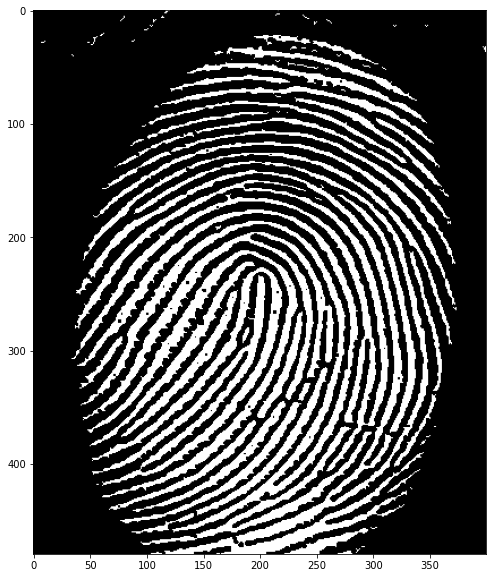

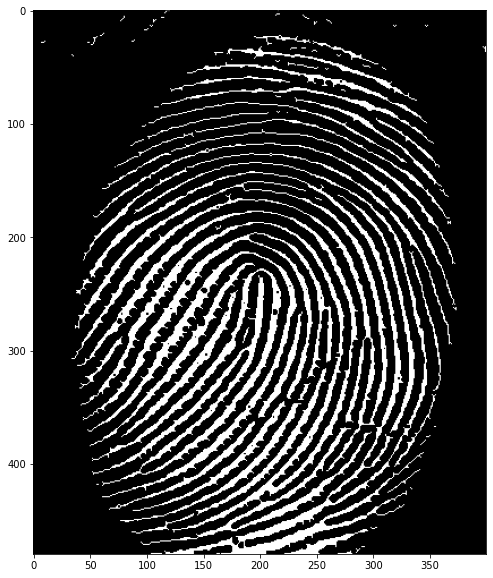

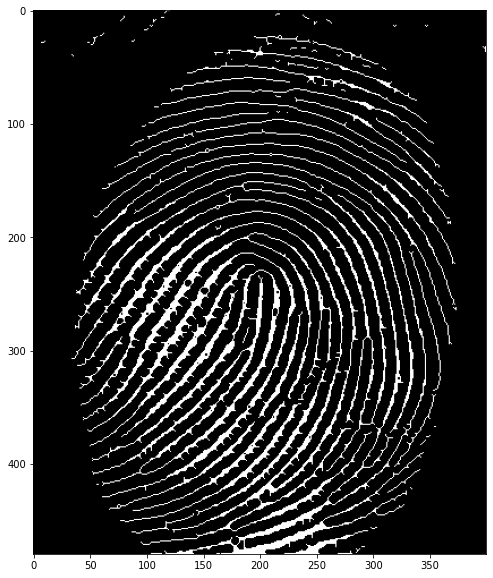

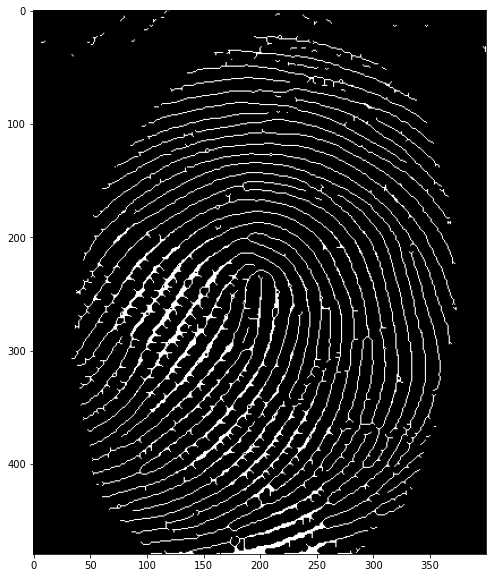

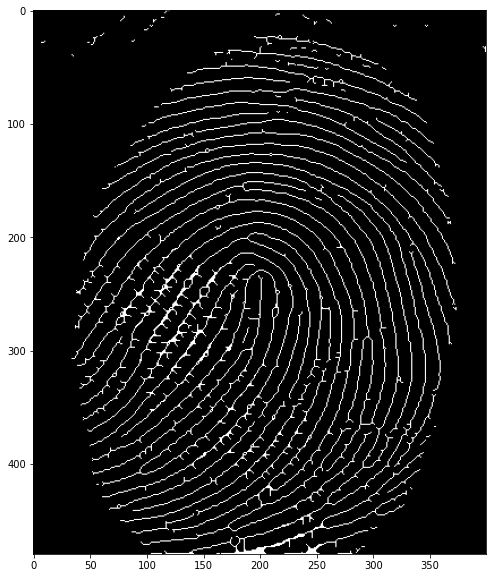

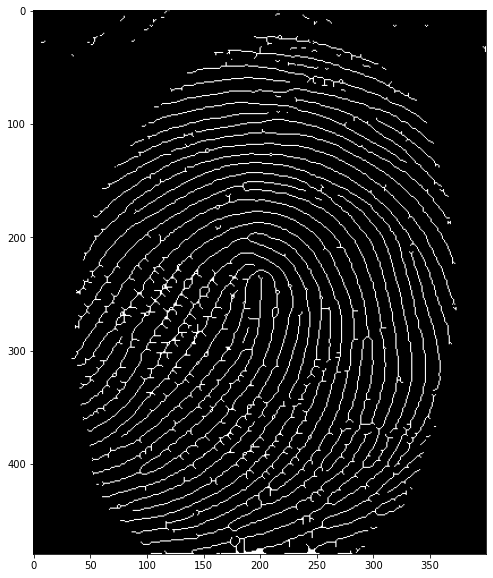

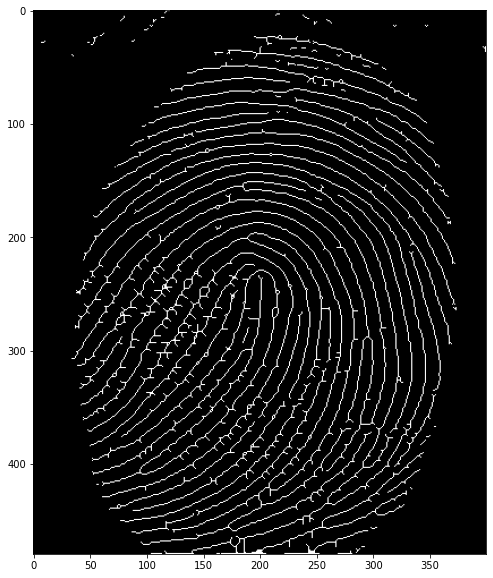

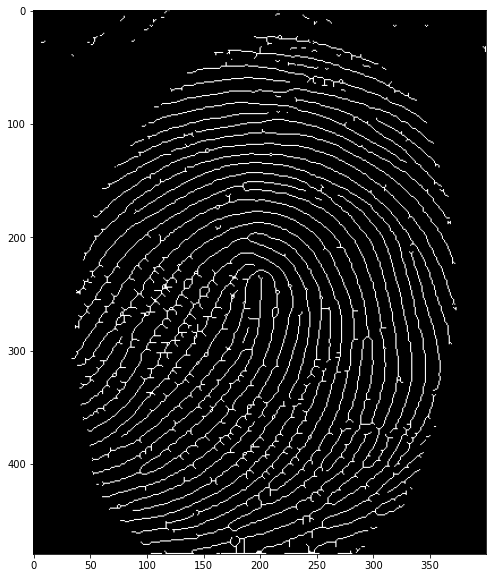

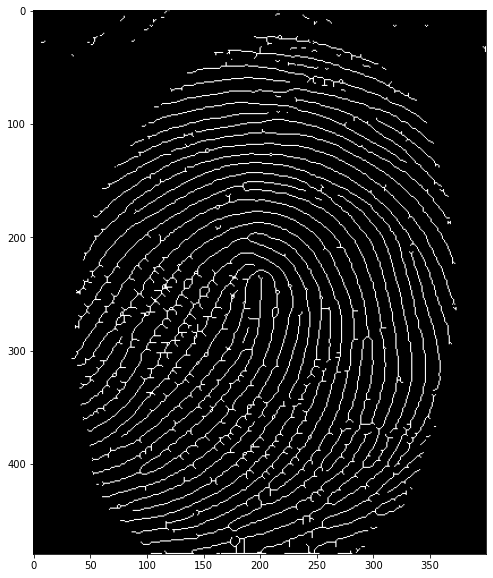

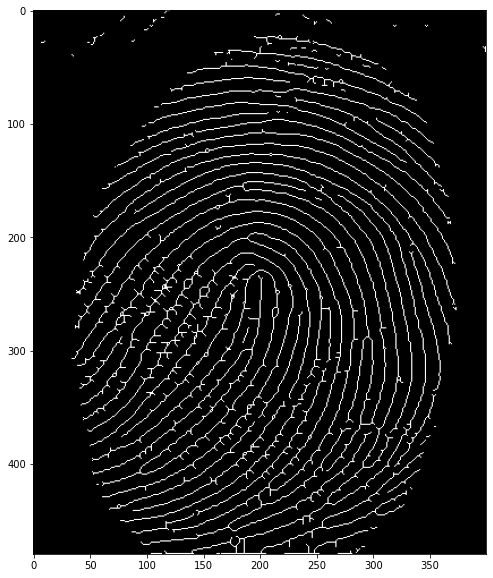

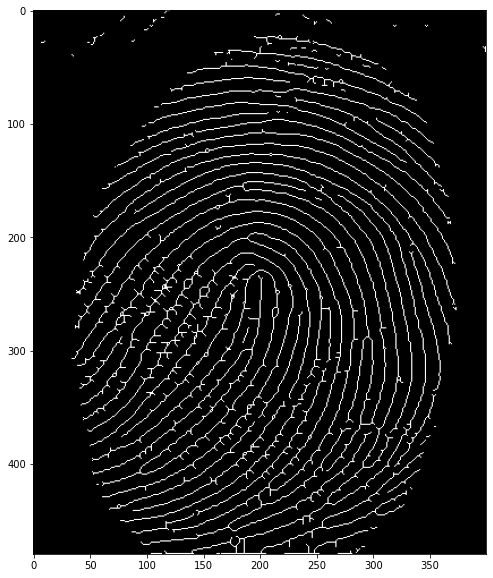

76.20689725875854


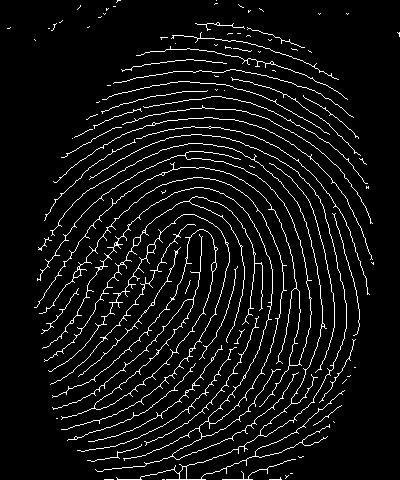

In [55]:
thumb = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "thumb_print.jpg") , 0)
i, ret = cv2.threshold(thumb,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret = 255 - ret
ret = np.uint8(ret/255)
t = time.time()
out = skeletonization(ret,True)
print (time.time()-t)
cv2_imshow(out * 255)

Part - 3: Multiple passes are required in skeletonization, since in one pass the boundaries and corners might not be completely removed, thus we need to do more passes until the boundaries and corners are completely removed to form a skeleton of the image.

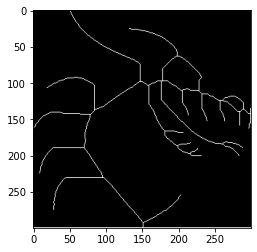

In [56]:
dragon = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "dragon.png") ,0)
_,dragon_t = cv2.threshold(dragon,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
dragon_out = skeletonization(np.uint8(dragon_t/255),False)

plt.imshow(dragon_out,cmap='gray')

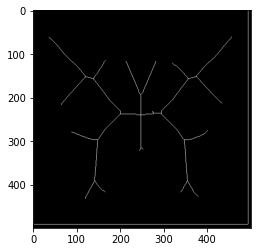

In [57]:
butterfly = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "butterfly.jpg") , 0)
_,butterfly_t = cv2.threshold(butterfly,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
butterfly_out = skeletonization(np.uint8(butterfly_t/255),False)

plt.imshow(butterfly_out,cmap='gray')

In [58]:
keyhole = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "keyhole.jpg") , 0)
_,keyhole_t = cv2.threshold(keyhole,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
keyhole_out = skeletonization(np.uint8(keyhole_t/255), False)

plt.imshow(keyhole_out,cmap='gray')

##Question 2

In [90]:
def unite(a, linked):
    while a != linked[a]:
        a = linked[a]
    return a
    
def unionSet(a, b, linked):
    linked[unite(a, linked)] = unite(b, linked)

def connComponents(im):
    next_label = 1;
    labels = np.zeros(im.shape, dtype=int)
    linked = [0]
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            if im[row, column]:
                neighbors = []
                if row > 0 and im[row-1][column] == im[row, column]:
                    neighbors.append((row-1, column))
                if row > 0 and column + 1 < im.shape[1] and im[row-1, column+1] == im[row, column]:
                    neighbors.append((row-1, column+1))
                if row > 0 and column > 0 and im[row-1, column-1] == im[row, column]:
                    neighbors.append((row-1, column-1))
                if column > 0 and im[row, column-1] == im[row, column]:
                    neighbors.append((row, column-1))

                if not neighbors:
                    linked.append(next_label)
                    labels[row, column] = next_label
                    next_label += 1
                else:
                    L = [labels[r, c] for r, c in neighbors]
                    labels[row, column] = min(L)
                    for label in L:
                        unionSet(label, labels[row, column], linked)
            
    for row in range(im.shape[0]):
        for column in range(im.shape[1]):
            if im[row, column]:
                labels[row, column] = unite(labels[row, column], linked)
    return labels


Text(0.5, 1.0, 'connected components')

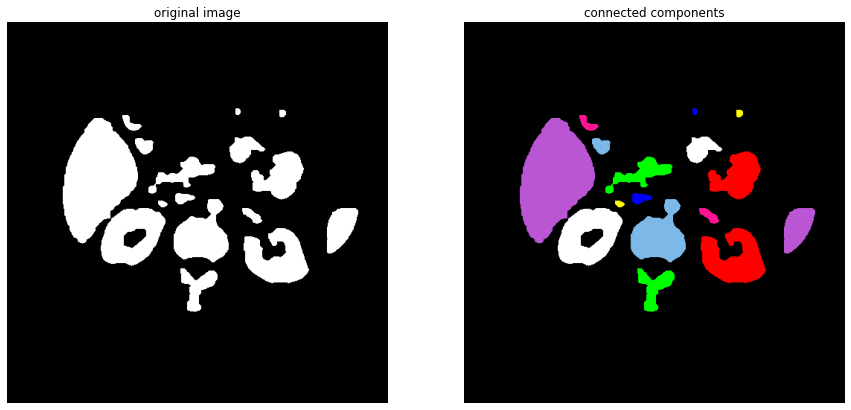

In [91]:
kidney = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "kidney.jpg"), cv2.IMREAD_GRAYSCALE)
kidney = (kidney > 132).astype(np.uint8)
kidney = cv2.morphologyEx(kidney, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6)))
kidney = cv2.morphologyEx(kidney, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
kidney = cv2.erode(kidney, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)), iterations = 3)
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255,20,147), (186,85,211), (255, 255, 255), (124,185,232), (196,98,16)]

output = np.zeros((kidney.shape[0], kidney.shape[1], 3))
conn = connComponents(kidney)
keys = np.unique(conn)
vals = list(range(1,len(keys) + 1))
dic = dict(zip(keys, vals))
row, col = kidney.shape
for c in range(len(vals)):
    for i in range(row):
        for j in range(col):
            if conn[i][j] != 0:
                for k in range(3):
                    output[i][j][k] = COLORS[dic[conn[i][j]] % 8][k]
output = output.astype(np.uint8)
fig, ax = plt.subplots(1, 2,figsize=(15,15))
ax[0].imshow(kidney,cmap='gray')
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('connected components')



##Question 3

In [92]:
sys.setrecursionlimit(100000)

def dfs(r, c):
    mov1 = [-1, 0, 1, 0]
    mov2 = [0, -1, 0, 1]
    for i in range(4):
        nr = r + mov1[i]
        nc = c + mov2[i]
        if nr >= 0 and nc >= 0 and nr < img.shape[0] and nc < img.shape[1] and img[nr][nc] and vis[nr][nc] == 0:
            vis[nr][nc] = 1
            dfs(nr,nc)

Text(0.5, 1.0, 'coins touching the boundary of the image')

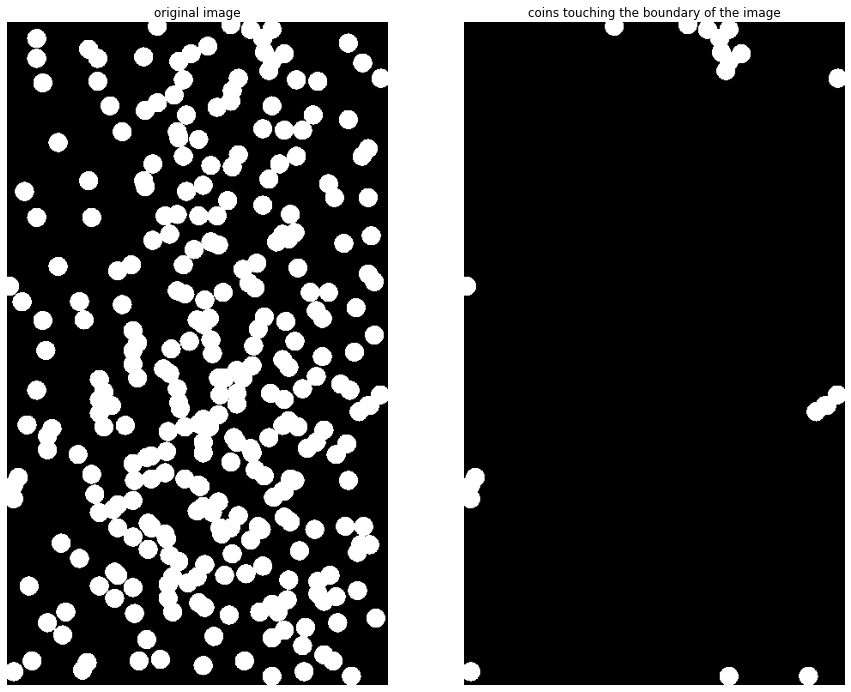

In [93]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "coins.jpg") , cv2.IMREAD_GRAYSCALE)
img = (img > 127).astype(np.uint8)
vis = np.zeros(img.shape)
for i in range(img.shape[0]):
    if img[i][0] and vis[i][0] == 0:
        vis[i][0] = 1
        dfs(i, 0)
for i in range(img.shape[1]):
    if img[0][i] and vis[0][i] == 0:
        vis[0][i] = 1
        dfs(0, i)
row, col = img.shape
for i in range(col):
    if img[row-1][i] != 0 and vis[row-1][i] == 0:
        vis[row-1][i] = 1
        dfs(row-1, i)
for i in range(row):
    if img[i][col-1] != 0 and vis[i][col-1] == 0:
        vis[i][col-1] = 1
        dfs(i, col-1)

fig, ax = plt.subplots(1, 2,figsize=(15,15))
ax[0].imshow(img,cmap='gray')
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(vis * 255,cmap='gray')
ax[1].axis('off')
ax[1].set_title('coins touching the boundary of the image')

In [94]:
def dfsOverlap(r, c, col):
    mov1 = [-1, 0, 1, 0]
    mov2 = [0, -1, 0, 1]
    sum = 1
    for i in range(4):
        nr = r + mov1[i]
        nc = c + mov2[i]
        if nr >= 0 and nc >= 0 and nr < img.shape[0] and nc < img.shape[1] and img[nr][nc] and visited[nr][nc] == 0:
            visited[nr][nc] = col
            sum = sum + dfsOverlap(nr,nc,col)
    return sum

Text(0.5, 1.0, 'non-overlapping coins')

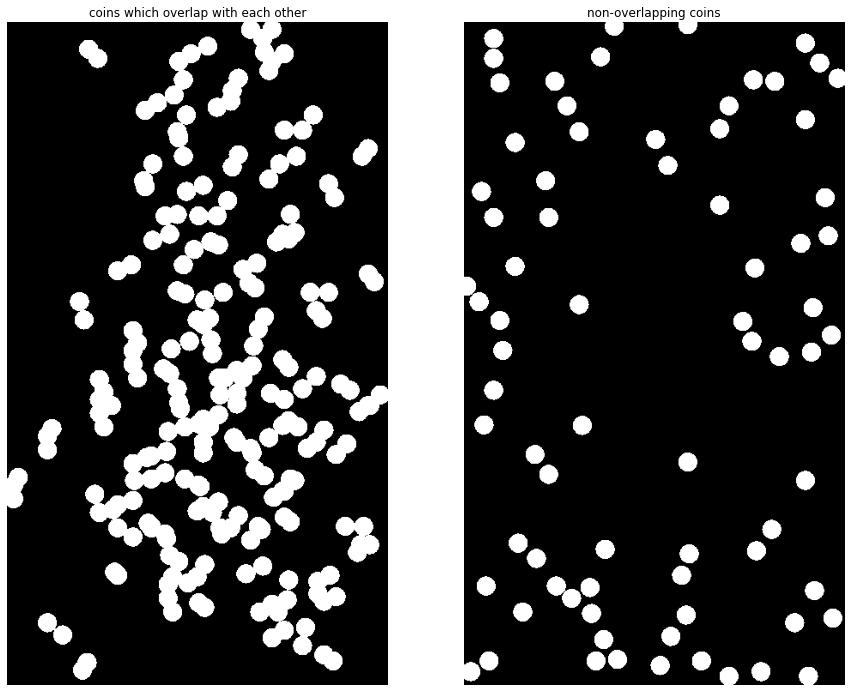

In [95]:
non_overlap_area = 450
color = 1
overlap_colors = {}
visited = np.zeros(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if visited[i][j] == 0 and img[i][j] == 1:
            if dfsOverlap(i, j, color) > non_overlap_area:
                overlap_colors[color] = 1
            color += 1

over = np.zeros(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if visited[i][j] in overlap_colors.keys():
            over[i][j] = 1

not_over = np.zeros(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if visited[i][j] not in overlap_colors.keys() and img[i][j]:
            not_over[i][j] = 1

fig, ax = plt.subplots(1, 2,figsize=(15,15))
ax[0].imshow(over * 255,cmap='gray')
ax[0].axis('off')
ax[0].set_title('coins which overlap with each other')

ax[1].imshow(not_over * 255,cmap='gray')
ax[1].axis('off')
ax[1].set_title('non-overlapping coins')


##Question 4


Text(0.5, 1.0, 'removing all holes')

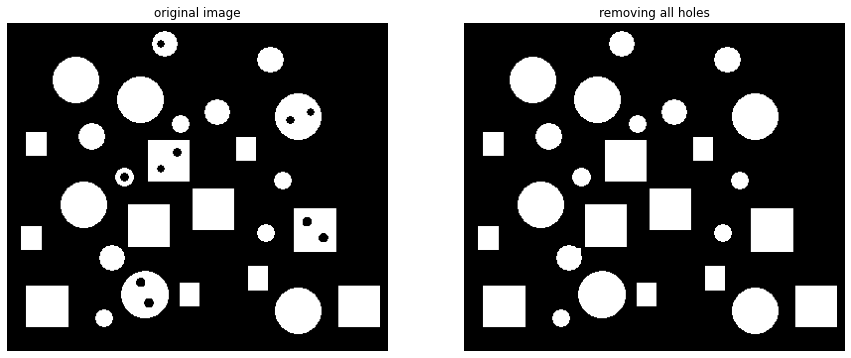

In [105]:
bim = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "objects.png") , cv2.IMREAD_GRAYSCALE)
bim = np.array(bim, np.uint8)
bim[bim > 0] = 1
cl_bim = cv2.morphologyEx(bim, cv2.MORPH_CLOSE, np.ones((7, 9)))

fig, ax = plt.subplots(1, 2,figsize=(15,15))

ax[0].imshow(bim,cmap='gray')
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(cl_bim,cmap='gray')
ax[1].axis('off')
ax[1].set_title('removing all holes')

In [97]:
vis = np.zeros(bim.shape)

def dfs(r, c, req):
    mov1 = [-1, 0, 1, 0]
    mov2 = [0, -1, 0, 1]
    for i in range(4):
        nr = r + mov1[i]
        nc = c + mov2[i]
        if nr >= 0 and nc >= 0 and nr < req.shape[0] and nc < req.shape[1] and req[nr][nc] and vis[nr][nc] == 0:
            vis[nr][nc] = 1
            dfs(nr, nc, req)

Count of objects that have one or more holes: 6


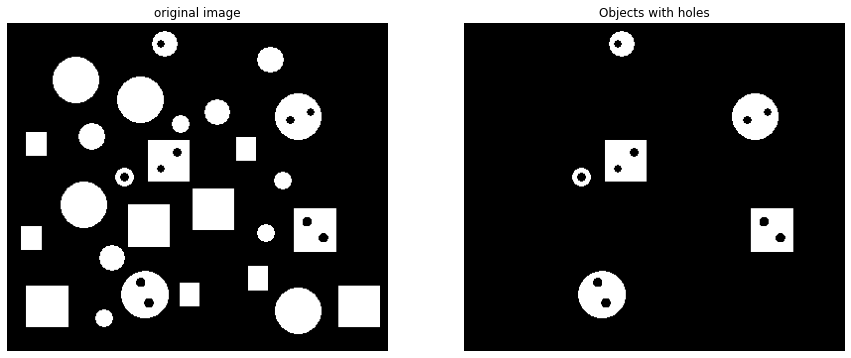

In [98]:
holes = cl_bim - bim
holes = cv2.morphologyEx(holes, cv2.MORPH_OPEN, np.ones((3, 3)))
sh = bim.shape
vis = np.zeros(sh)
newim = np.zeros(sh, np.uint)
c = 0

for i in range(sh[0]):
    for j in range(sh[1]):
        if holes[i][j] == 1:
            c += (vis[i][j] == 0)
            dfs(i, j, cl_bim)
            
newim_holes = np.logical_and(vis, bim)

fig, ax = plt.subplots(1, 2,figsize=(15,15))

ax[0].imshow(bim,cmap='gray')
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(newim_holes,cmap='gray')
ax[1].axis('off')
ax[1].set_title('Objects with holes')
print(str(c))

Count of square objects in the image: 11


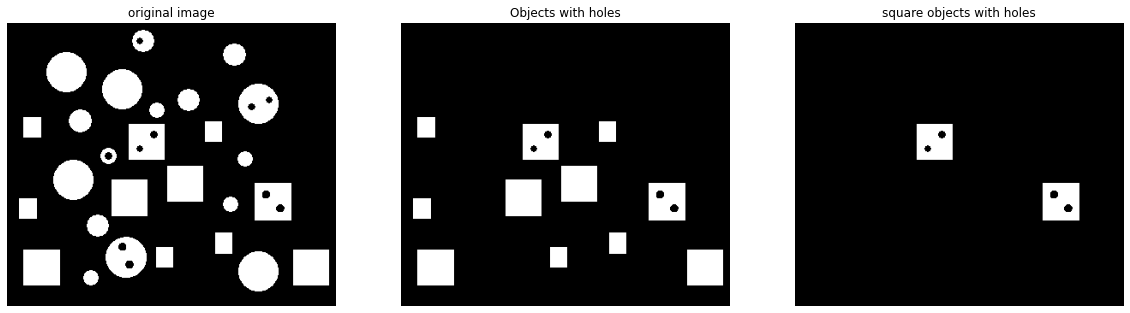

In [99]:
fil = np.array([[0, 0, 0],
                [1, 1, 0],
                [1, 1, 0]])
vis = np.zeros(sh)
newim = np.zeros(sh, np.uint)
def conv(im, fil):
    newim = np.copy(im)
    im = np.pad(im, (1, 1), 'constant')
    for i in range(1, im.shape[0] - 1):
        for j in range(1, im.shape[1] - 1):
            part = im[i - 1: i + 2, j - 1: j + 2]
            f = 0
            for x in range(part.shape[0]):
                for y in range(part.shape[1]):
                    if part[x][y] != fil[x][y]:
                        f = 1
            newim[i - 1, j - 1] = 1 if f == 0 else 0
    return newim

c = 0
corners = conv(bim, fil)
for i in range(sh[0]):
    for j in range(sh[1]):
        if corners[i][j] == 1:
            c += (vis[i][j] == 0)
            dfs(i, j, bim)

newim_squares = vis

newim_sqs_and_holes = np.logical_and(newim_holes, newim_squares)

fig, ax = plt.subplots(1, 3,figsize=(20,20))

ax[0].imshow(bim,cmap='gray')
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(newim_squares,cmap='gray')
ax[1].axis('off')
ax[1].set_title('Objects with holes')

ax[2].imshow(newim_sqs_and_holes,cmap='gray')
ax[2].axis('off')
ax[2].set_title('square objects with holes')
print(str(c))

Text(0.5, 1.0, 'circle objects without holes')

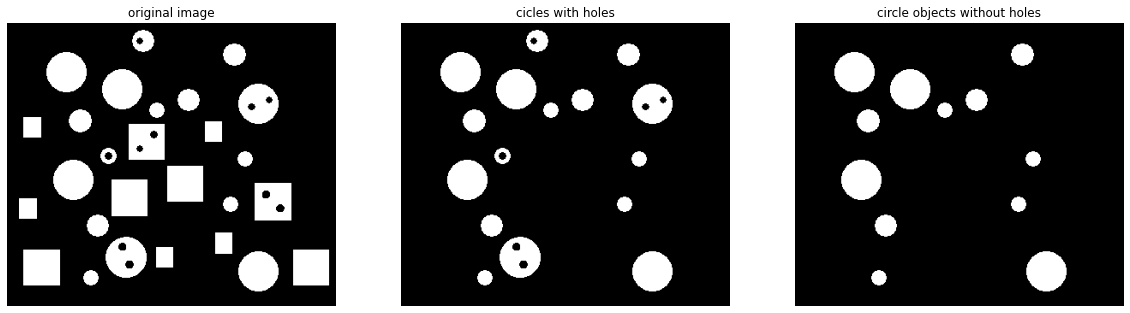

In [100]:
newim_circles = bim - newim_squares
newim_circles_holes = np.logical_and(newim_circles, newim_holes)
newim_circles_no_holes = newim_circles - newim_circles_holes

fig, ax = plt.subplots(1, 3,figsize=(20,20))

ax[0].imshow(bim,cmap='gray')
ax[0].axis('off')
ax[0].set_title('original image')

ax[1].imshow(newim_circles,cmap='gray')
ax[1].axis('off')
ax[1].set_title('cicles with holes')

ax[2].imshow(newim_circles_no_holes,cmap='gray')
ax[2].axis('off')
ax[2].set_title('circle objects without holes')

##Question 5

In [101]:
image =  cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "colourful_text.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[15:-15,15:-15]

im = np.copy(image)
rows, cols, channels = im.shape
color = []
mx_count = 0
im = np.reshape(im, [np.shape(im)[0] * np.shape(im)[1], 3])
color, counts = np.unique(im, axis=0, return_counts=True)
ind = counts.argsort()
clrs = color[ind][-6:][:5]

In [102]:
from collections import Counter
a = [1,2,3,1,2,1,1,1,3,2,2,1]
b = Counter(a)
print(b.most_common(1))

[(1, 6)]


##Question 6

## How do we upscale by a factor k?

1. We first we create a new image with the new scaled dimensions filled with zeros.
2. Then, we do backward mapping for each pixel of the new image by dividing the x-coordinate with the scaling factor along the x direction and the y-coordinate by the scaling factor along the y direction.

The main problem arises here
- We can either choose some form of interpolation method or choose the neared integer value to location of the pixel intensity we want to choose from the original image.

- Suppose we choose an interpolation method (say averaging), we average over all the nearby pixel values, thus corrupting the label (we get a completely new label which never existed in the first place).

- If we choose nearest integer, we will obtain a label which is already existing thus ensuring that no new labels are created.

## How do we rotate by angle theta

1. We first we create a new image with the new dimensions filled with zeros.
2. Then, we do backward mapping for each pixel of the new image by multiplying a pixel location with the inverse of the transformation matrix.

The main problem arises here
- We can either choose some form of interpolation method or choose the neared integer value to location of the pixel intensity we want to choose from the original image.

- Suppose we choose an interpolation method (say averaging), we average over all the nearby pixel values, thus corrupting the label (we get a completely new label which never existed in the first place).

- If we choose nearest integer neighbour, we will obtain a label which is already existing thus ensuring that no new labels are created.

##Question 7

In [106]:
def rotImage(img,x,crop):
   
    rad = (np.pi * x) / 180
    a, b = img.shape
    x0, y0 = a//2-1, b//2-1
    
    if crop == False:
        if rad>=0 and rad<=np.pi*0.5:
            A = (x0 + (-x0)*np.cos(rad)+(-y0)*np.sin(rad) ).astype('int64')
            B = (y0 - (-x0)*np.sin(rad)+(b-1-y0)*np.cos(rad) ).astype('int64')
            C = (x0 + (a-1-x0)*np.cos(rad)+(b-1-y0)*np.sin(rad) ).astype('int64')
            D = (y0 - (a-1-x0)*np.sin(rad)+(-y0)*np.cos(rad) ).astype('int64')
            m = (abs(A) + abs(C))
            n = (abs(B) + abs(D))
            k1 = abs(A)
            k2 = abs(D)
            
        elif rad > np.pi * 0.5 and rad <= np.pi:
            A=(x0 +(x0)*np.cos(rad)+(-y0)*np.sin(rad) ).astype('int64')
            B=(y0 -(-x0)*np.sin(rad)-(b-1-y0)*np.cos(rad) ).astype('int64')
            C=(x0 -(a-1-x0)*np.cos(rad)+(b-1-y0)*np.sin(rad) ).astype('int64')
            D=(y0 -(a-1-x0)*np.sin(rad)+(y0)*np.cos(rad) ).astype('int64')
            m = (abs(A) + abs(C))
            n = (abs(B) + abs(D))
            k1 = abs(A)
            k2 = abs(D)
            
        elif rad > np.pi and rad <= np.pi * 1.5:
            A = (x0 + (x0) * np.cos(rad) + (y0)*np.sin(rad) ).astype('int64')
            B = (y0 - (x0) * np.sin(rad) - (b-1-y0)*np.cos(rad) ).astype('int64')
            C = (x0 - (a-1-x0) * np.cos(rad) - (b-1-y0)*np.sin(rad) ).astype('int64')
            D = (y0 + (a-1-x0) * np.sin(rad) + (y0)*np.cos(rad) ).astype('int64')
            m = (abs(A)+abs(C))
            n = (abs(D)+abs(B))
            k1 = abs(A)
            k2 = abs(D)


        else:
            A = (x0 + (-x0) * np.cos(rad)+(y0)*np.sin(rad)).astype('int64')
            B = (y0 - (x0) * np.sin(rad)+(b-1-y0)*np.cos(rad)).astype('int64')
            C = (x0 + (a-1-x0) * np.cos(rad) - (b-1-y0)*np.sin(rad)).astype('int64')
            D = (y0 + (a-1-x0) * np.sin(rad) + (-y0)*np.cos(rad)).astype('int64')
            k1 = abs(A)
            k2 = abs(D)
            m = (abs(A) + abs(C))
            n = (abs(D) + abs(B))    
        
        T = np.array([[np.cos(rad) , np.sin(rad), x0], [-np.sin(rad), np.cos(rad), y0], [0, 0, 1]],dtype='float64')
        T1 = np.linalg.inv(T)       
        new_img = np.ones((m,n)) * 120

        for i in range(m):
            for j in range(n):
                X = np.array([[i-k1, j-k2, 1]]).T
                X1 = T1@X
                x1 = (x0 + X1[0]).astype('int64')
                y1 = (y0 + X1[1]).astype('int64')
                if (x1 < a and x1 >= 0 and y1 >= 0 and y1 < b):
                    new_img[i,j] = img[x1,y1]
        return new_img
    
    else:           
        rad = -rad
        new_img = np.ones((a,b)) * 120
        for i in range(a):
            for j in range(b):
                x1 = (x0 + (i-x0)*np.cos(rad)+(j-y0)*np.sin(rad) ).astype('int64')
                y1 = (y0 - (i-x0)*np.sin(rad)+(j-y0)*np.cos(rad) ).astype('int64')
                if (x1 < a and x1 >= 0 and y1 >= 0 and y1 < b):
                    new_img[i,j]=img[x1,y1]
        return new_img

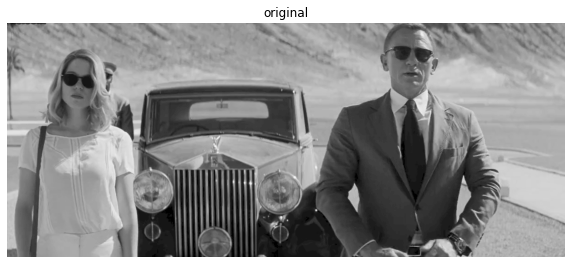

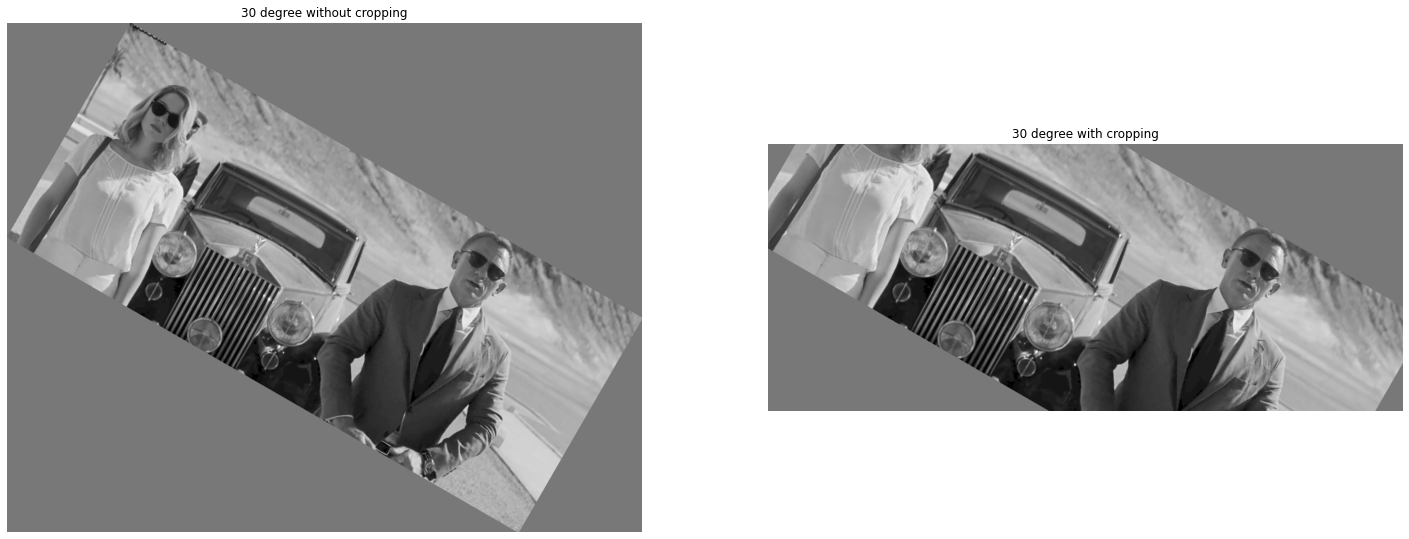

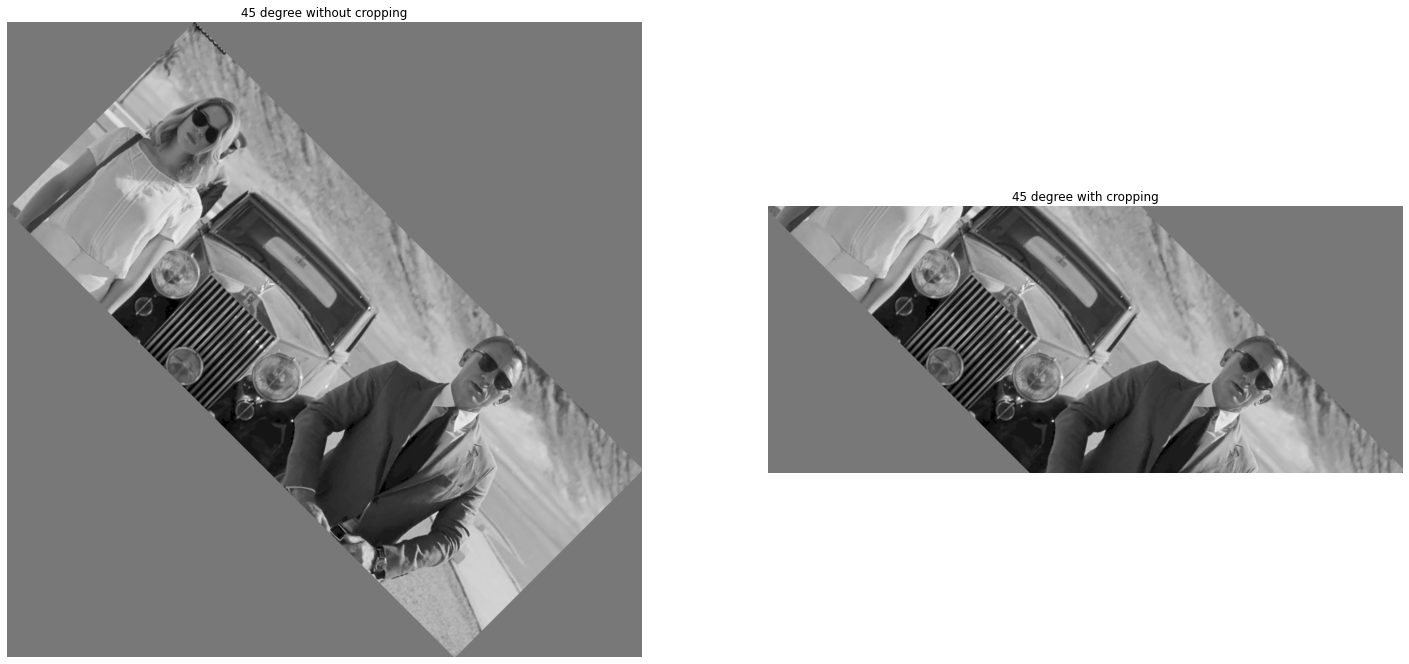

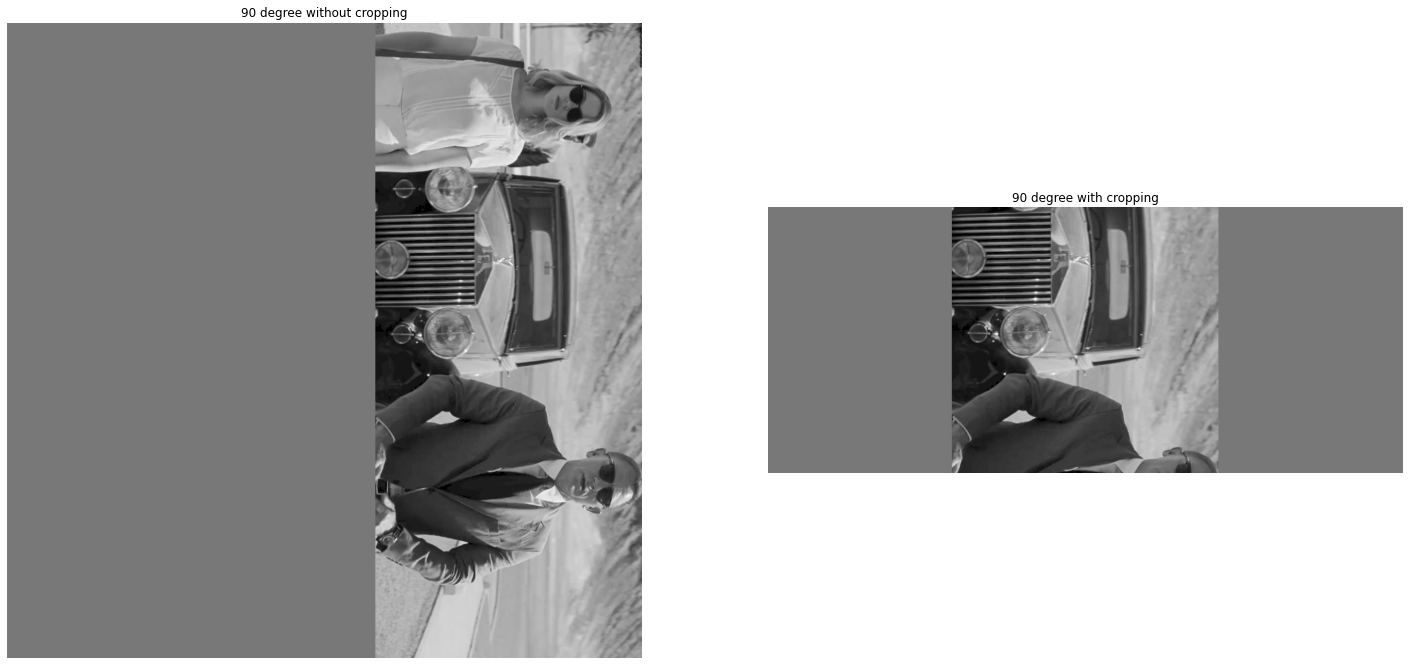

Text(0.5, 1.0, '300 degree with cropping')

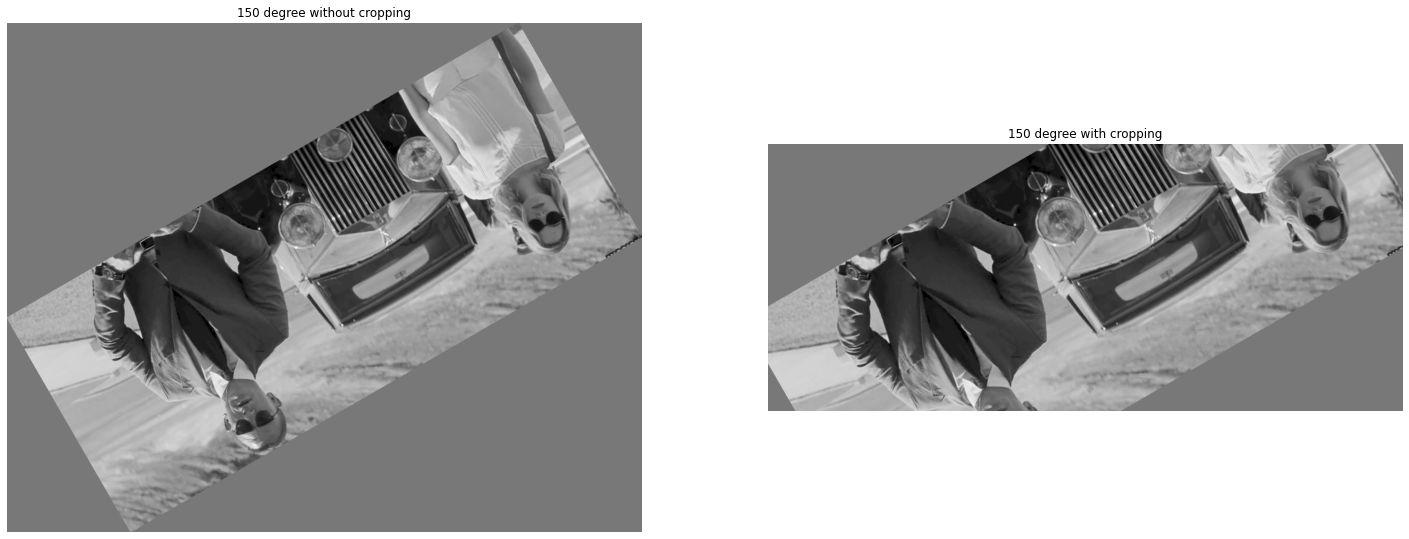

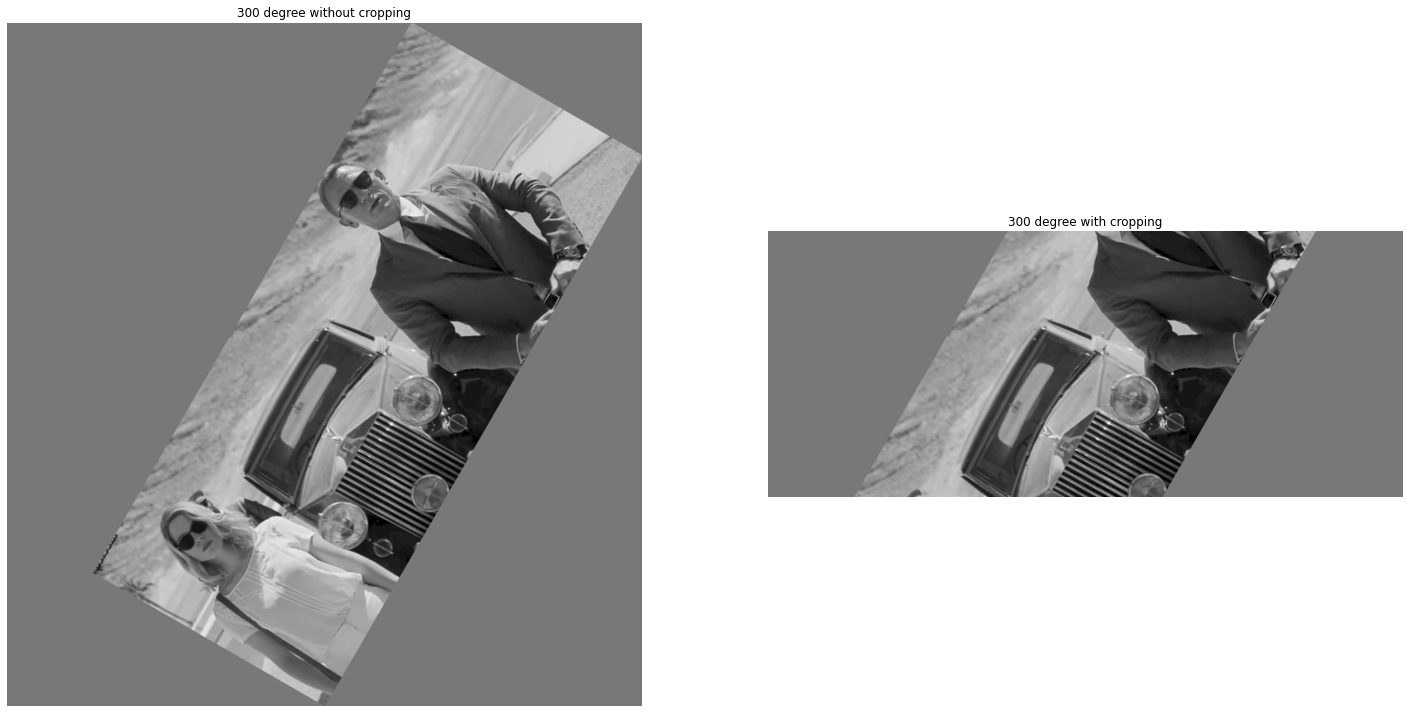

In [107]:
image = cv2.imread('sahara2.png',0)
image = image[:,100:]

plt.figure(figsize=(10,10))
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.title("original")
plt.show()

plt.figure(figsize=(25,15))

plt.subplot(1,2,1)
plt.imshow(rotImage(image,30,False),cmap='gray')
plt.axis('off')
plt.title("30 degree without cropping")
plt.subplot(1,2,2)
plt.imshow(rotImage(image,30,True),cmap='gray')
plt.axis('off')
plt.title("30 degree with cropping")
plt.show()


plt.figure(figsize=(25,15))

plt.subplot(1,2,1)
plt.imshow(rotImage(image,45,False),cmap='gray')
plt.axis('off')
plt.title("45 degree without cropping")
plt.subplot(1,2,2)
plt.imshow(rotImage(image,45,True),cmap='gray')
plt.axis('off')
plt.title("45 degree with cropping")
plt.show()


plt.figure(figsize=(25,15))

plt.subplot(1,2,1)
plt.imshow(rotImage(image,90,False),cmap='gray')
plt.axis('off')
plt.title("90 degree without cropping")
plt.subplot(1,2,2)
plt.imshow(rotImage(image,90,True),cmap='gray')
plt.axis('off')
plt.title("90 degree with cropping")
plt.show()


plt.figure(figsize=(25,15))

plt.subplot(1,2,1)
plt.imshow(rotImage(image,150,False),cmap='gray')
plt.axis('off')
plt.title("150 degree without cropping")
plt.subplot(1,2,2)
plt.imshow(rotImage(image,150,True),cmap='gray')
plt.axis('off')
plt.title("150 degree with cropping")


plt.figure(figsize=(25,15))

plt.subplot(1,2,1)
plt.imshow(rotImage(image,300,False),cmap='gray')
plt.axis('off')
plt.title("300 degree without cropping")
plt.subplot(1,2,2)
plt.imshow(rotImage(image,300,True),cmap='gray')
plt.axis('off')
plt.title("300 degree with cropping")